# Data

In [1]:
%run nearest_mrt_station_to_bus_stops.ipynb

25548it [00:23, 1106.52it/s]


## MRT Stations Data

In [2]:
# mrt stations geodataframe
import os
os.environ['OGR_GEOMETRY_ACCEPT_UNCLOSED_RING'] = 'NO'

mrt_stations_gdf = geopandas.read_file('./TrainStation_Jul2024/RapidTransitSystemStation.shp')
mrt_stations_gdf_3857 = mrt_stations_gdf.to_crs(3857)
mrt_stations_gdf_3857

,TYP_CD,STN_NAM,ATTACHEMEN,TYP_CD_DES,STN_NAM_DE,geometry
0,0,None,None,MRT,GALI BATU DEPOT,"POLYGON ((11549880.181 155286.262, 11549893.09..."
1,0,None,None,MRT,HILLVIEW MRT STATION,"POLYGON ((11551320.421 151685.479, 11551324.86..."
2,0,None,None,MRT,BEAUTY WORLD MRT STATION,"POLYGON ((11552265.127 149269.279, 11552255.26..."
3,0,None,None,MRT,HUME MRT STATION,"POLYGON ((11551478.151 150855.083, 11551485.53..."
4,0,None,None,MRT,BUKIT PANJANG MRT STATION,"POLYGON ((11550666.118 153603.709, 11550698.62..."
...,...,...,...,...,...,...
225,0,None,None,MRT,KATONG PARK MRT STATION,"POLYGON ((11564432.509 144548.028, 11564447.75..."
226,0,None,None,MRT,MARINE TERRACE MRT STATION,"POLYGON ((11567908.523 145472.086, 11567908.42..."
227,0,None,None,MRT,TANJONG RHU MRT STATION,"POLYGON ((11563110.672 144334.178, 11563108.03..."
228,0,None,None,MRT,MARINE PARADE MRT STATION,"POLYGON ((11566600.443 144955.407, 11566582.69..."


In [3]:
mrt_stations_gdf2 = geopandas.read_file('./mrt_stations/mrt_stations.shp')

mrt_stations_gdf2["lat_lng"] = geopandas.points_from_xy(mrt_stations_gdf2["LATITUDE"], mrt_stations_gdf2["LONGITUDE"])
mrt_stations_gdf2["line"] = mrt_stations_gdf2["CODE"].str.slice(0, 2) 

mrt_lines_code = ["NS", "EW", "CC", "NE", "TE", "DT"]

mrt_gdf_wo_lrt = mrt_stations_gdf2[mrt_stations_gdf2["line"].isin(mrt_lines_code)].reset_index()
mrt_gdf_wo_lrt = mrt_gdf_wo_lrt.drop("index", axis = 1)

mrt_gdf_wo_lrt["STN_NAM_DE"] = mrt_gdf_wo_lrt["BUILDING"].str.split('(').str[0].str.strip()
mrt_stations_3857_2 = mrt_gdf_wo_lrt.merge(mrt_stations_gdf_3857, how = "left", on = "STN_NAM_DE")

mrt_stations_3857_2

,CODE,STATION_NA,LINE,COLOR,OPENING,TYPE,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,...,LONGITUDE,geometry_x,lat_lng,line,STN_NAM_DE,TYP_CD,STN_NAM,ATTACHEMEN,TYP_CD_DES,geometry_y
0,NS1,Jurong East,North-South Line,Red,1990-03-10,MRT,JURONG EAST MRT STATION (EW24 / NS1),10,JURONG EAST STREET 12,JURONG EAST MRT STATION (EW24 / NS1),...,103.742286332403,POINT (17869.057 35038.969),POINT (1.333 103.742),NS,JURONG EAST MRT STATION,0,None,None,MRT,"POLYGON ((11548513.722 148484.605, 11548515.37..."
1,NS2,Bukit Batok,North-South Line,Red,1990-03-10,MRT,BUKIT BATOK MRT STATION (NS2),10,BUKIT BATOK CENTRAL,BUKIT BATOK MRT STATION (NS2),...,103.749566478309,POINT (18679.322 36794.926),POINT (1.349 103.75),NS,BUKIT BATOK MRT STATION,0,None,None,MRT,"POLYGON ((11549318.598 150099.924, 11549295.94..."
2,NS3,Bukit Gombak,North-South Line,Red,1990-03-10,MRT,BUKIT GOMBAK MRT STATION (NS3),802,BUKIT BATOK WEST AVENUE 5,BUKIT GOMBAK MRT STATION (NS3),...,103.751790910733,POINT (18926.913 37854.036),POINT (1.359 103.752),NS,BUKIT GOMBAK MRT STATION,0,None,None,MRT,"POLYGON ((11549629.35 151190.998, 11549628.967..."
3,NS4,Choa Chu Kang,North-South Line,Red,1990-03-10,MRT,CHOA CHU KANG MRT STATION (NS4),10,CHOA CHU KANG AVENUE 4,CHOA CHU KANG MRT STATION (NS4),...,103.744370779756,POINT (18101.247 40812.122),POINT (1.385 103.744),NS,CHOA CHU KANG MRT STATION,0,None,None,MRT,"POLYGON ((11548794.664 154207.851, 11548779.42..."
4,NS5,Yew Tee,North-South Line,Red,1996-02-10,MRT,YEW TEE MRT STATION (NS5),61,CHOA CHU KANG DRIVE,YEW TEE MRT STATION (NS5),...,103.747405150236,POINT (18438.983 42158.018),POINT (1.398 103.747),NS,YEW TEE MRT STATION,0,None,None,MRT,"POLYGON ((11549092.655 155476.939, 11549088.92..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,TE20,Marina Bay,Thomson-East Coast Line,Brown,2022-11-13,MRT,MARINA BAY MRT STATION (TE20),25,PARK STREET,MARINA BAY MRT STATION (TE20),...,103.855309167928,POINT (30447.379 28579.995),POINT (1.275 103.855),TE,MARINA BAY MRT STATION,0,None,CE2_MRB STN.zip,MRT,"POLYGON ((11561070.528 141987.904, 11561054.72..."
207,TE20,Marina Bay,Thomson-East Coast Line,Brown,2022-11-13,MRT,MARINA BAY MRT STATION (TE20),25,PARK STREET,MARINA BAY MRT STATION (TE20),...,103.855309167928,POINT (30447.379 28579.995),POINT (1.275 103.855),TE,MARINA BAY MRT STATION,0,None,None,MRT,"POLYGON ((11561039.437 141991.719, 11561036.58..."
208,TE20,Marina Bay,Thomson-East Coast Line,Brown,2022-11-13,MRT,MARINA BAY MRT STATION (TE20),25,PARK STREET,MARINA BAY MRT STATION (TE20),...,103.855309167928,POINT (30447.379 28579.995),POINT (1.275 103.855),TE,MARINA BAY MRT STATION,0,None,None,MRT,"POLYGON ((11561017.163 142126.143, 11561004.19..."
209,TE20,Marina Bay,Thomson-East Coast Line,Brown,2022-11-13,MRT,MARINA BAY MRT STATION (TE20),25,PARK STREET,MARINA BAY MRT STATION (TE20),...,103.855309167928,POINT (30447.379 28579.995),POINT (1.275 103.855),TE,MARINA BAY MRT STATION,0,None,None,MRT,"POLYGON ((11561104.449 141953.568, 11561129.46..."


## Bus Routes Data

In [4]:
from shapely.geometry import LineString

# combine bus routes
bus_routes_combined = bus_routes_gdf_3857.groupby(['ServiceNo', 'Direction']).apply(lambda x: LineString(x.geometry.tolist())).reset_index()
bus_routes_combined.columns = ['ServiceNo', 'Direction', 'geometry']
bus_routes_combined

/var/folders/d0/twkl0gkd7lv67r2q_sxfmpnw0000gn/T/ipykernel_2833/1680479668.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bus_routes_combined = bus_routes_gdf_3857.groupby(['ServiceNo', 'Direction']).apply(lambda x: LineString(x.geometry.tolist())).reset_index()


,ServiceNo,Direction,geometry
0,10,1,LINESTRING (11570925.355747303 150749.03122670...
1,10,2,LINESTRING (11551610.561061133 144087.88490860...
2,100,1,LINESTRING (11562943.630025776 150347.12028417...
3,100,2,LINESTRING (11553774.516701924 145960.08849871...
4,100A,1,LINESTRING (11562943.630025776 150347.12028417...
...,...,...,...
719,992,1,LINESTRING (11549515.381030776 150294.50067879...
720,992,2,LINESTRING (11547835.02338783 151709.373424986...
721,993,1,LINESTRING (11548357.891036088 148329.89223418...
722,9A,1,LINESTRING (11569327.609406518 147460.11332459...


# Thomson-East Coast Line (Brown)

In [5]:
brown_line = ['WOODLANDS NORTH MRT STATION',
              'WOODLANDS MRT STATION',
              'WOODLANDS SOUTH MRT STATION',
              'SPRINGLEAF MRT STATION',
              'LENTOR MRT STATION',
              'MAYFLOWER MRT STATION',
              'BRIGHT HILL MRT STATION',
              'UPPER THOMSON MRT STATION',
              'CALDECOTT MRT STATION',
              'STEVENS MRT STATION',
              'NAPIER MRT STATION',
              'ORCHARD BOULEVARD MRT STATION',
              'ORCHARD MRT STATION',
              'GREAT WORLD MRT STATION',
              'HAVELOCK MRT STATION',
              'OUTRAM PARK MRT STATION',
              'MAXWELL MRT STATION',
              'SHENTON WAY MRT STATION',
              'MARINA BAY MRT STATION',
              'GARDENS BY THE BAY MRT STATION',
              'TANJONG RHU MRT STATION',
              'KATONG PARK MRT STATION',
              'TANJONG KATONG MRT STATION',
              'MARINE PARADE MRT STATION',
              'MARINE TERRACE MRT STATION',
              'SIGLAP MRT STATION',
              'BAYSHORE MRT STATION',
              'BEDOK SOUTH MRT STATION',
              'SUNGEI BEDOK MRT STATION']

# filter brown line stations from mrt stations geodataframe
brown_line_stations_gdf = mrt_stations_gdf_3857[mrt_stations_gdf_3857['STN_NAM_DE'].isin(brown_line)]

# order brown line stations based on list
brown_line_stations_gdf['STN_NAM_DE'] = pd.Categorical(brown_line_stations_gdf['STN_NAM_DE'],
                                                       categories = brown_line,
                                                       ordered = True)
brown_line_stations_gdf = brown_line_stations_gdf.sort_values('STN_NAM_DE')
brown_line_stations_gdf


,TYP_CD,STN_NAM,ATTACHEMEN,TYP_CD_DES,STN_NAM_DE,geometry
192,0,None,None,MRT,WOODLANDS NORTH MRT STATION,"POLYGON ((11553290.504 161340.499, 11553308.78..."
196,0,None,None,MRT,WOODLANDS MRT STATION,"POLYGON ((11553655.571 159844.445, 11553714.07..."
177,0,None,None,MRT,WOODLANDS MRT STATION,"POLYGON ((11553305.733 159892.909, 11553302.44..."
191,0,None,None,MRT,WOODLANDS SOUTH MRT STATION,"POLYGON ((11554340.403 158819.168, 11554344.10..."
187,0,None,None,MRT,SPRINGLEAF MRT STATION,"POLYGON ((11556983.209 155700.488, 11556972.59..."
110,0,None,None,MRT,LENTOR MRT STATION,"POLYGON ((11559127.808 154037.405, 11559127.68..."
219,0,None,None,MRT,MAYFLOWER MRT STATION,"POLYGON ((11559099.098 152920.462, 11559094.58..."
186,0,None,None,MRT,BRIGHT HILL MRT STATION,"POLYGON ((11558731.827 151811.306, 11558686.82..."
217,0,None,None,MRT,UPPER THOMSON MRT STATION,"POLYGON ((11558480.214 150916.092, 11558483.67..."
218,0,None,None,MRT,CALDECOTT MRT STATION,"POLYGON ((11559462.068 148993.215, 11559463.61..."


In [6]:
# ordered list of brown line station coordinates
brown_line_stations_gdf['coordinates'] = brown_line_stations_gdf['geometry'].centroid
brown_line_stations_gdf

# create a linestring for the brown line route
from shapely.geometry import LineString
brown_line_route = LineString(brown_line_stations_gdf['coordinates'])

## Brown Line Route Visualisation

In [7]:
import folium
import geopandas
from shapely.geometry import mapping

# convert brown_line_route from LineString to geodataframe
brown_line_route_gdf = geopandas.GeoDataFrame(geometry = [brown_line_route], crs = "EPSG:3857")
brown_line_route_gdf_4326 = brown_line_route_gdf.to_crs(4326)

# create base map
brown_line_map = folium.Map(location = (1.359394, 103.814301), zoom_start = 12)

# add brown line route layer
folium.GeoJson(
    data = mapping(brown_line_route_gdf_4326),
    name = 'TEL',
    style_function = lambda x: {
        'color': 'brown',
        'weight': 4
    }
).add_to(brown_line_map)

brown_line_map


In [8]:
# calculate the overlapping distance of each bus route and the brown line
buffer_distance = 100
buffered_brown_line = brown_line_route.buffer(buffer_distance)

overlap_distance_output_brown = []

for i, route in tqdm(bus_routes_combined.iterrows()):
    overlap = buffered_brown_line.intersection(route.geometry)
    if overlap.is_empty:
        overlap_distance_output_brown.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': 0,
            'MRT line': 'Thomson-East Coast Line',
            'Intersection': overlap
            })
    else:
        overlap_distance_output_brown.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': overlap.length,
            'MRT line': 'Thomson-East Coast Line',
            'Intersection': overlap
            })

overlap_distance_brown = geopandas.GeoDataFrame(overlap_distance_output_brown)
overlap_distance_brown

238it [00:00, 1181.21it/s]

724it [00:00, 1154.97it/s]


,Bus Service,Direction,Overlap Distance,MRT line,Intersection
0,10,1,202.104821,Thomson-East Coast Line,LINESTRING (11560535.393136496 142373.36841972...
1,10,2,202.201316,Thomson-East Coast Line,LINESTRING (11560313.114541788 142253.17195882...
2,100,1,202.104821,Thomson-East Coast Line,LINESTRING (11560535.393136496 142373.36841972...
3,100,2,202.722867,Thomson-East Coast Line,LINESTRING (11560313.114541788 142253.17195882...
4,100A,1,0.000000,Thomson-East Coast Line,LINESTRING Z EMPTY
...,...,...,...,...,...
719,992,1,0.000000,Thomson-East Coast Line,LINESTRING Z EMPTY
720,992,2,0.000000,Thomson-East Coast Line,LINESTRING Z EMPTY
721,993,1,0.000000,Thomson-East Coast Line,LINESTRING Z EMPTY
722,9A,1,0.000000,Thomson-East Coast Line,LINESTRING Z EMPTY


In [9]:
# filter bus routes with overlap
bus_routes_overlap_brown = overlap_distance_brown[overlap_distance_brown['Overlap Distance'] > 0].sort_values(by = 'Overlap Distance', ascending = False)
bus_routes_overlap_brown

,Bus Service,Direction,Overlap Distance,MRT line,Intersection
349,36,1,10712.453056,Thomson-East Coast Line,MULTILINESTRING ((11570247.489187447 145943.63...
351,36B,1,9578.456098,Thomson-East Coast Line,MULTILINESTRING ((11569767.053458788 145922.54...
392,47,1,6577.674498,Thomson-East Coast Line,MULTILINESTRING ((11569834.788487667 146040.89...
350,36A,1,5153.463902,Thomson-East Coast Line,MULTILINESTRING ((11570247.489187447 145943.63...
225,196e,1,5141.642547,Thomson-East Coast Line,MULTILINESTRING ((11569767.053458788 145922.54...
...,...,...,...,...,...
182,178,1,75.541516,Thomson-East Coast Line,LINESTRING (11553397.54702328 159976.868225107...
184,178A,1,75.541516,Thomson-East Coast Line,LINESTRING (11553397.54702328 159976.868225107...
183,178,2,73.841224,Thomson-East Coast Line,LINESTRING (11553323.707102172 159976.42962111...
619,911A,1,54.494540,Thomson-East Coast Line,LINESTRING (11553375.39444461 159966.066837988...


In [10]:
bus_routes_overlap = bus_routes_overlap_brown
bus_routes_overlap

,Bus Service,Direction,Overlap Distance,MRT line,Intersection
349,36,1,10712.453056,Thomson-East Coast Line,MULTILINESTRING ((11570247.489187447 145943.63...
351,36B,1,9578.456098,Thomson-East Coast Line,MULTILINESTRING ((11569767.053458788 145922.54...
392,47,1,6577.674498,Thomson-East Coast Line,MULTILINESTRING ((11569834.788487667 146040.89...
350,36A,1,5153.463902,Thomson-East Coast Line,MULTILINESTRING ((11570247.489187447 145943.63...
225,196e,1,5141.642547,Thomson-East Coast Line,MULTILINESTRING ((11569767.053458788 145922.54...
...,...,...,...,...,...
182,178,1,75.541516,Thomson-East Coast Line,LINESTRING (11553397.54702328 159976.868225107...
184,178A,1,75.541516,Thomson-East Coast Line,LINESTRING (11553397.54702328 159976.868225107...
183,178,2,73.841224,Thomson-East Coast Line,LINESTRING (11553323.707102172 159976.42962111...
619,911A,1,54.494540,Thomson-East Coast Line,LINESTRING (11553375.39444461 159966.066837988...


# Downtown Line (Blue)

In [11]:
blue_line = ['SUNGEI KADUT MRT STATION',
             'BUKIT PANJANG MRT STATION',
             'CASHEW MRT STATION',
             'HILLVIEW MRT STATION',
             'HUME MRT STATION',
             'BEAUTY WORLD MRT STATION',
             'KING ALBERT PARK MRT STATION',
             'SIXTH AVENUE MRT STATION',
             'TAN KAH KEE MRT STATION',
             'BOTANIC GARDENS MRT STATION',
             'STEVENS MRT STATION',
             'NEWTON MRT STATION',
             'LITTLE INDIA MRT STATION',
             'ROCHOR MRT STATION',
             'BUGIS MRT STATION',
             'PROMENADE MRT STATION',
             'BAYFRONT MRT STATION',
             'DOWNTOWN MRT STATION',
             'TELOK AYER MRT STATION',
             'CHINATOWN MRT STATION',
             'FORT CANNING MRT STATION',
             'BENCOOLEN MRT STATION',
             'JALAN BESAR MRT STATION',
             'BENDEMEER MRT STATION',
             'GEYLANG BAHRU MRT STATION',
             'MATTAR MRT STATION',
             'MACPHERSON MRT STATION',
             'UBI MRT STATION',
             'KAKI BUKIT MRT STATION',
             'BEDOK NORTH MRT STATION',
             'BEDOK RESERVOIR MRT STATION',
             'TAMPINES WEST MRT STATION',
             'TAMPINES MRT STATION',
             'TAMPINES EAST MRT STATION',
             'UPPER CHANGI MRT STATION',
             'EXPO MRT STATION']

# filter blue line stations from mrt stations geodataframe
blue_line_stations_gdf = mrt_stations_gdf_3857[mrt_stations_gdf_3857['STN_NAM_DE'].isin(blue_line)]

# order blue line stations based on list
blue_line_stations_gdf['STN_NAM_DE'] = pd.Categorical(blue_line_stations_gdf['STN_NAM_DE'],
                                                       categories = blue_line,
                                                       ordered = True)
blue_line_stations_gdf = blue_line_stations_gdf.sort_values('STN_NAM_DE')
blue_line_stations_gdf



,TYP_CD,STN_NAM,ATTACHEMEN,TYP_CD_DES,STN_NAM_DE,geometry
4,0,None,None,MRT,BUKIT PANJANG MRT STATION,"POLYGON ((11550666.118 153603.709, 11550698.62..."
5,0,None,None,MRT,CASHEW MRT STATION,"POLYGON ((11551010.357 152545.896, 11551024.66..."
1,0,None,None,MRT,HILLVIEW MRT STATION,"POLYGON ((11551320.421 151685.479, 11551324.86..."
3,0,None,None,MRT,HUME MRT STATION,"POLYGON ((11551478.151 150855.083, 11551485.53..."
2,0,None,None,MRT,BEAUTY WORLD MRT STATION,"POLYGON ((11552265.127 149269.279, 11552255.26..."
67,0,None,None,MRT,KING ALBERT PARK MRT STATION,"POLYGON ((11553177.948 148708.332, 11553217.08..."
33,0,None,None,MRT,SIXTH AVENUE MRT STATION,"POLYGON ((11554594.564 148204.756, 11554598.90..."
216,0,None,None,MRT,TAN KAH KEE MRT STATION,"POLYGON ((11555673.915 147692.277, 11555708.09..."
125,0,None,None,MRT,BOTANIC GARDENS MRT STATION,"POLYGON ((11556730.423 147258.342, 11556757.97..."
108,0,None,CC19_BTN STN.zip,MRT,BOTANIC GARDENS MRT STATION,"POLYGON ((11556592.183 147107.79, 11556577.023..."


In [12]:
# ordered list of blue line station coordinates
blue_line_stations_gdf['coordinates'] = blue_line_stations_gdf['geometry'].centroid
blue_line_stations_gdf

# create a linestring for the blue line route
from shapely.geometry import LineString
blue_line_route = LineString(blue_line_stations_gdf['coordinates'])

In [13]:
# calculate the overlapping distance of each bus route and the blue line
buffer_distance = 150
buffered_blue_line = blue_line_route.buffer(buffer_distance)

overlap_distance_output = []

for i, route in tqdm(bus_routes_combined.iterrows()):
    overlap = buffered_blue_line.intersection(route.geometry)
    if overlap.is_empty:
        overlap_distance_output.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': 0,
            'MRT line': 'Downtown Line',
            'Intersection': overlap
            })
    else:
        overlap_distance_output.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': overlap.length,
            'MRT line': 'Downtown Line',
            'Intersection': overlap
            })

overlap_distance_blue = pd.DataFrame(overlap_distance_output)
overlap_distance_blue

724it [00:00, 794.72it/s] 


,Bus Service,Direction,Overlap Distance,MRT line,Intersection
0,10,1,1085.722634,Downtown Line,MULTILINESTRING ((11570925.355747303 150749.03...
1,10,2,1091.514007,Downtown Line,MULTILINESTRING ((11560467.9015176 142498.5760...
2,100,1,914.021723,Downtown Line,MULTILINESTRING ((11563916.236846302 147736.57...
3,100,2,914.707723,Downtown Line,MULTILINESTRING ((11560471.86652475 142496.094...
4,100A,1,304.650635,Downtown Line,LINESTRING (11563916.236846302 147736.57459673...
...,...,...,...,...,...
719,992,1,0.000000,Downtown Line,LINESTRING Z EMPTY
720,992,2,0.000000,Downtown Line,LINESTRING Z EMPTY
721,993,1,0.000000,Downtown Line,LINESTRING Z EMPTY
722,9A,1,1183.825625,Downtown Line,LINESTRING (11572522.697139109 149919.17555404...


In [14]:
# filter bus routes with overlap with blue line
bus_routes_overlap_blue = overlap_distance_blue[overlap_distance_blue['Overlap Distance'] > 0].sort_values(by = 'Overlap Distance', ascending = False)
bus_routes_overlap_blue

,Bus Service,Direction,Overlap Distance,MRT line,Intersection
478,67,2,16091.462313,Downtown Line,MULTILINESTRING ((11570925.355747303 150749.03...
477,67,1,14353.211924,Downtown Line,MULTILINESTRING ((11550550.736296788 153470.92...
164,170,1,13688.136207,Downtown Line,MULTILINESTRING ((11561192.006549314 145157.14...
252,23,1,12961.825736,Downtown Line,MULTILINESTRING ((11570925.355747303 150749.03...
165,170,2,12815.664331,Downtown Line,MULTILINESTRING ((11550642.20390868 153685.769...
...,...,...,...,...,...
53,123,2,191.817440,Downtown Line,LINESTRING (11559741.604025243 143841.34664826...
63,129A,1,30.953370,Downtown Line,LINESTRING (11570187.875770293 149738.22617307...
630,922,1,10.275598,Downtown Line,MULTILINESTRING ((11550876.228613876 153427.09...
629,920,1,10.275598,Downtown Line,MULTILINESTRING ((11550876.228613876 153427.09...


In [15]:
bus_routes_overlap = pd.concat([bus_routes_overlap, bus_routes_overlap_blue], axis = 0)
bus_routes_overlap

,Bus Service,Direction,Overlap Distance,MRT line,Intersection
349,36,1,10712.453056,Thomson-East Coast Line,MULTILINESTRING ((11570247.489187447 145943.63...
351,36B,1,9578.456098,Thomson-East Coast Line,MULTILINESTRING ((11569767.053458788 145922.54...
392,47,1,6577.674498,Thomson-East Coast Line,MULTILINESTRING ((11569834.788487667 146040.89...
350,36A,1,5153.463902,Thomson-East Coast Line,MULTILINESTRING ((11570247.489187447 145943.63...
225,196e,1,5141.642547,Thomson-East Coast Line,MULTILINESTRING ((11569767.053458788 145922.54...
...,...,...,...,...,...
53,123,2,191.817440,Downtown Line,LINESTRING (11559741.604025243 143841.34664826...
63,129A,1,30.953370,Downtown Line,LINESTRING (11570187.875770293 149738.22617307...
630,922,1,10.275598,Downtown Line,MULTILINESTRING ((11550876.228613876 153427.09...
629,920,1,10.275598,Downtown Line,MULTILINESTRING ((11550876.228613876 153427.09...


# North-East Line (Purple)

In [16]:
purple_line = [
    'HARBOURFRONT MRT STATION',
    'OUTRAM PARK MRT STATION',
    'CHINATOWN MRT STATION',
    'CLARKE QUAY MRT STATION',
    'DHOBY GHAUT MRT STATION',
    'LITTLE INDIA MRT STATION',
    'FARRER PARK MRT STATION',
    'BOON KENG MRT STATION',
    'POTONG PASIR MRT STATION',
    'WOODLEIGH MRT STATION',
    'SERANGOON MRT STATION',
    'KOVAN MRT STATION',
    'HOUGANG MRT STATION',
    'BUANGKOK MRT STATION',
    'SENGKANG MRT STATION',
    'PUNGGOL MRT STATION'
]


# filter purple line stations from mrt stations geodataframe
purple_line_stations_gdf = mrt_stations_gdf_3857[mrt_stations_gdf_3857['STN_NAM_DE'].isin(purple_line)]

# order purple line stations based on list
purple_line_stations_gdf['STN_NAM_DE'] = pd.Categorical(purple_line_stations_gdf['STN_NAM_DE'],
                                                       categories = purple_line,
                                                       ordered = True)
purple_line_stations_gdf = purple_line_stations_gdf.sort_values('STN_NAM_DE')
purple_line_stations_gdf

,TYP_CD,STN_NAM,ATTACHEMEN,TYP_CD_DES,STN_NAM_DE,geometry
157,0,None,CC29_HBF STN.zip,MRT,HARBOURFRONT MRT STATION,"POLYGON ((11557408.287 140823.192, 11557327.29..."
63,0,None,NE1_HBF STN.zip,MRT,HARBOURFRONT MRT STATION,"POLYGON ((11557256.56 140840.359, 11557256.277..."
201,0,None,None,MRT,OUTRAM PARK MRT STATION,"POLYGON ((11559308.372 142682.402, 11559298.43..."
117,0,None,NE3_OTP STN.zip,MRT,OUTRAM PARK MRT STATION,"POLYGON ((11559350.232 142623.057, 11559353.15..."
84,0,None,C109_S_OTP_MAIN_A_R19_P2.zip,MRT,OUTRAM PARK MRT STATION,"POLYGON ((11559237.753 142695.209, 11559251.83..."
169,0,None,None,MRT,CHINATOWN MRT STATION,"POLYGON ((11559751.172 143121.613, 11559752.03..."
92,0,None,NE4_CNT STN.zip,MRT,CHINATOWN MRT STATION,"POLYGON ((11559695.295 142864.198, 11559671.98..."
91,0,None,NE5_CQY STN.zip,MRT,CLARKE QUAY MRT STATION,"POLYGON ((11560054.558 143242.668, 11560050.58..."
6,0,None,None,MRT,DHOBY GHAUT MRT STATION,"POLYGON ((11559965.996 144666.945, 11560032.60..."
90,0,None,NE6_DBG STN.zip,MRT,DHOBY GHAUT MRT STATION,"POLYGON ((11560057.669 144610.631, 11560099.83..."


In [17]:
# ordered list of purple line station coordinates
purple_line_stations_gdf['coordinates'] = purple_line_stations_gdf['geometry'].centroid
purple_line_stations_gdf

# create a linestring for the purple line route
from shapely.geometry import LineString
purple_line_route = LineString(purple_line_stations_gdf['coordinates'])

In [18]:
# calculate the overlapping distance of each bus route and the purple line
buffer_distance = 150
buffered_purple_line = purple_line_route.buffer(buffer_distance)

overlap_distance_output = []

for i, route in tqdm(bus_routes_combined.iterrows()):
    overlap = buffered_purple_line.intersection(route.geometry)
    if overlap.is_empty:
        overlap_distance_output.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': 0,
            'MRT line': 'North-East Line',
            'Intersection': overlap
            })
    else:
        overlap_distance_output.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': overlap.length,
            'MRT line': 'North-East Line',
            'Intersection': overlap
            })

overlap_distance_purple = pd.DataFrame(overlap_distance_output)
overlap_distance_purple

104it [00:00, 1032.70it/s]

724it [00:00, 882.46it/s] 


,Bus Service,Direction,Overlap Distance,MRT line,Intersection
0,10,1,595.777236,North-East Line,LINESTRING (11557764.771169078 141046.73889461...
1,10,2,636.280118,North-East Line,LINESTRING (11557216.441459887 140947.51394543...
2,100,1,1981.580285,North-East Line,MULTILINESTRING ((11562943.630025776 150347.12...
3,100,2,1628.347311,North-East Line,MULTILINESTRING ((11557216.441459887 140947.51...
4,100A,1,1385.803049,North-East Line,MULTILINESTRING ((11562943.630025776 150347.12...
...,...,...,...,...,...
719,992,1,0.000000,North-East Line,LINESTRING Z EMPTY
720,992,2,0.000000,North-East Line,LINESTRING Z EMPTY
721,993,1,0.000000,North-East Line,LINESTRING Z EMPTY
722,9A,1,0.000000,North-East Line,LINESTRING Z EMPTY


In [19]:
# filter bus routes with overlap with purple line
bus_routes_overlap_purple = overlap_distance_purple[overlap_distance_purple['Overlap Distance'] > 0].sort_values(by = 'Overlap Distance', ascending = False)
bus_routes_overlap_purple

,Bus Service,Direction,Overlap Distance,MRT line,Intersection
19,107M,1,11014.797338,North-East Line,MULTILINESTRING ((11565278.908793872 152589.82...
108,147,2,7635.060619,North-East Line,MULTILINESTRING ((11558621.89527276 142203.761...
5,101,1,6218.377800,North-East Line,MULTILINESTRING ((11562943.630025776 150347.12...
539,82,1,6197.415788,North-East Line,MULTILINESTRING ((11566344.824867642 156275.50...
18,107,2,5808.077146,North-East Line,MULTILINESTRING ((11562354.096129265 147456.09...
...,...,...,...,...,...
310,3,1,100.239040,North-East Line,LINESTRING (11566445.01405314 156272.343263043...
12,105,2,73.741523,North-East Line,LINESTRING (11562884.180792421 150390.75055812...
22,109A,1,71.285963,North-East Line,LINESTRING (11562943.630025776 150347.12028417...
8,102B,1,70.896183,North-East Line,LINESTRING (11565506.87539269 155096.450562328...


In [20]:
bus_routes_overlap = pd.concat([bus_routes_overlap, bus_routes_overlap_purple], axis = 0)
bus_routes_overlap

,Bus Service,Direction,Overlap Distance,MRT line,Intersection
349,36,1,10712.453056,Thomson-East Coast Line,MULTILINESTRING ((11570247.489187447 145943.63...
351,36B,1,9578.456098,Thomson-East Coast Line,MULTILINESTRING ((11569767.053458788 145922.54...
392,47,1,6577.674498,Thomson-East Coast Line,MULTILINESTRING ((11569834.788487667 146040.89...
350,36A,1,5153.463902,Thomson-East Coast Line,MULTILINESTRING ((11570247.489187447 145943.63...
225,196e,1,5141.642547,Thomson-East Coast Line,MULTILINESTRING ((11569767.053458788 145922.54...
...,...,...,...,...,...
310,3,1,100.239040,North-East Line,LINESTRING (11566445.01405314 156272.343263043...
12,105,2,73.741523,North-East Line,LINESTRING (11562884.180792421 150390.75055812...
22,109A,1,71.285963,North-East Line,LINESTRING (11562943.630025776 150347.12028417...
8,102B,1,70.896183,North-East Line,LINESTRING (11565506.87539269 155096.450562328...


# North-South Line (Red)

In [21]:
red_line = mrt_stations_3857_2[mrt_stations_3857_2["line"] == "NS"]["STATION_NA"].tolist()

# filter red line stations from mrt stations geodataframe
red_line_stations_gdf = mrt_stations_3857_2[mrt_stations_3857_2['line'] == "NS"]

red_line_stations_gdf["order"] = pd.to_numeric(red_line_stations_gdf["CODE"].str.slice(2, None))

# order red line stations based on list
red_line_stations_gdf = red_line_stations_gdf.sort_values('order')
red_line_stations_gdf

,CODE,STATION_NA,LINE,COLOR,OPENING,TYPE,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,...,geometry_x,lat_lng,line,STN_NAM_DE,TYP_CD,STN_NAM,ATTACHEMEN,TYP_CD_DES,geometry_y,order
0,NS1,Jurong East,North-South Line,Red,1990-03-10,MRT,JURONG EAST MRT STATION (EW24 / NS1),10,JURONG EAST STREET 12,JURONG EAST MRT STATION (EW24 / NS1),...,POINT (17869.057 35038.969),POINT (1.333 103.742),NS,JURONG EAST MRT STATION,0,None,None,MRT,"POLYGON ((11548513.722 148484.605, 11548515.37...",1
1,NS2,Bukit Batok,North-South Line,Red,1990-03-10,MRT,BUKIT BATOK MRT STATION (NS2),10,BUKIT BATOK CENTRAL,BUKIT BATOK MRT STATION (NS2),...,POINT (18679.322 36794.926),POINT (1.349 103.75),NS,BUKIT BATOK MRT STATION,0,None,None,MRT,"POLYGON ((11549318.598 150099.924, 11549295.94...",2
2,NS3,Bukit Gombak,North-South Line,Red,1990-03-10,MRT,BUKIT GOMBAK MRT STATION (NS3),802,BUKIT BATOK WEST AVENUE 5,BUKIT GOMBAK MRT STATION (NS3),...,POINT (18926.913 37854.036),POINT (1.359 103.752),NS,BUKIT GOMBAK MRT STATION,0,None,None,MRT,"POLYGON ((11549629.35 151190.998, 11549628.967...",3
3,NS4,Choa Chu Kang,North-South Line,Red,1990-03-10,MRT,CHOA CHU KANG MRT STATION (NS4),10,CHOA CHU KANG AVENUE 4,CHOA CHU KANG MRT STATION (NS4),...,POINT (18101.247 40812.122),POINT (1.385 103.744),NS,CHOA CHU KANG MRT STATION,0,None,None,MRT,"POLYGON ((11548794.664 154207.851, 11548779.42...",4
4,NS5,Yew Tee,North-South Line,Red,1996-02-10,MRT,YEW TEE MRT STATION (NS5),61,CHOA CHU KANG DRIVE,YEW TEE MRT STATION (NS5),...,POINT (18438.983 42158.018),POINT (1.398 103.747),NS,YEW TEE MRT STATION,0,None,None,MRT,"POLYGON ((11549092.655 155476.939, 11549088.92...",5
5,NS7,Kranji,North-South Line,Red,1996-02-10,MRT,KRANJI MRT STATION (NS7),960,WOODLANDS ROAD,KRANJI MRT STATION (NS7),...,POINT (20078.587 45204.517),POINT (1.425 103.762),NS,KRANJI MRT STATION,0,None,None,MRT,"POLYGON ((11550658.471 158600.225, 11550639.63...",7
6,NS8,Marsiling,North-South Line,Red,1996-02-10,MRT,MARSILING MRT STATION (NS8),71,WOODLANDS AVENUE 3,MARSILING MRT STATION (NS8),...,POINT (21407.041 46026.513),POINT (1.433 103.774),NS,MARSILING MRT STATION,0,None,None,MRT,"POLYGON ((11551976.264 159472.321, 11551970.71...",8
7,NS9,Woodlands,North-South Line,Red,1996-02-10,MRT,WOODLANDS MRT STATION (NS9),30,WOODLANDS AVENUE 2,WOODLANDS MRT STATION (NS9),...,POINT (22741.598 46501.786),POINT (1.437 103.786),NS,WOODLANDS MRT STATION,0,None,None,MRT,"POLYGON ((11553305.733 159892.909, 11553302.44...",9
8,NS9,Woodlands,North-South Line,Red,1996-02-10,MRT,WOODLANDS MRT STATION (NS9),30,WOODLANDS AVENUE 2,WOODLANDS MRT STATION (NS9),...,POINT (22741.598 46501.786),POINT (1.437 103.786),NS,WOODLANDS MRT STATION,0,None,None,MRT,"POLYGON ((11553655.571 159844.445, 11553714.07...",9
9,NS10,Admiralty,North-South Line,Red,1996-02-10,MRT,ADMIRALTY MRT STATION (NS10),70,WOODLANDS AVENUE 7,ADMIRALTY MRT STATION (NS10),...,POINT (24402.387 46918.507),POINT (1.441 103.801),NS,ADMIRALTY MRT STATION,0,None,None,MRT,"POLYGON ((11554977.061 160321.073, 11554965.95...",10


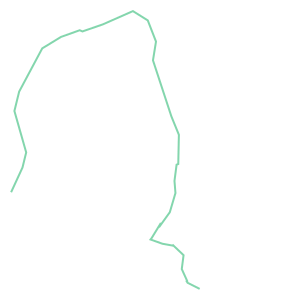

In [22]:
# ordered list of red line station coordinates
red_line_stations_gdf['coordinates'] = red_line_stations_gdf['geometry_y'].centroid
red_line_stations_gdf


# create a linestring for the red line route
from shapely.geometry import LineString
red_line_route = LineString(red_line_stations_gdf['coordinates'])
red_line_route

In [23]:
buffered_red_line = red_line_route.buffer(buffer_distance)

overlap_distance_output_red = []

for i, route in tqdm(bus_routes_combined.iterrows()):
    overlap = buffered_red_line.intersection(route.geometry)
    if overlap.is_empty:
        overlap_distance_output_red.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': 0,
            'MRT line': 'North-South Line',
            'Intersection': overlap
            })
    else:
        overlap_distance_output_red.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': overlap.length,
            'MRT line': 'North-South Line',
            'Intersection': overlap
            })

overlap_distance_red = pd.DataFrame(overlap_distance_output_red)
overlap_distance_red

724it [00:00, 1295.87it/s]


,Bus Service,Direction,Overlap Distance,MRT line,Intersection
0,10,1,379.090761,North-South Line,LINESTRING (11560860.19886347 142945.099205560...
1,10,2,390.720082,North-South Line,LINESTRING (11560626.539900236 142734.05695945...
2,100,1,379.090761,North-South Line,LINESTRING (11560860.19886347 142945.099205560...
3,100,2,390.720082,North-South Line,LINESTRING (11560626.539900236 142734.05695945...
4,100A,1,0.000000,North-South Line,LINESTRING Z EMPTY
...,...,...,...,...,...
719,992,1,341.661387,North-South Line,LINESTRING (11549515.381030776 150294.50067879...
720,992,2,367.918292,North-South Line,LINESTRING (11549272.438556815 150513.65593801...
721,993,1,0.000000,North-South Line,LINESTRING Z EMPTY
722,9A,1,0.000000,North-South Line,LINESTRING Z EMPTY


In [24]:
bus_routes_overlap_red = overlap_distance_red[overlap_distance_red['Overlap Distance'] > 0].sort_values(by = 'Overlap Distance', ascending = False)
bus_routes_overlap_red

,Bus Service,Direction,Overlap Distance,MRT line,Intersection
666,965,1,10583.682845,North-South Line,MULTILINESTRING ((11553436.063567095 160044.46...
572,858,1,6501.666038,North-South Line,MULTILINESTRING ((11553397.54702328 159976.868...
682,972M,1,6287.758118,North-South Line,MULTILINESTRING ((11559199.100152956 146381.00...
152,167,2,6205.492234,North-South Line,MULTILINESTRING ((11560581.53592856 142833.190...
552,851e,1,5865.484698,North-South Line,MULTILINESTRING ((11558981.499660706 159025.23...
...,...,...,...,...,...
88,138B,1,41.758910,North-South Line,LINESTRING (11560369.616077418 152487.46172084...
292,269A,1,37.884108,North-South Line,LINESTRING (11560369.616077418 152487.46172084...
181,177,1,23.956965,North-South Line,MULTILINESTRING ((11549515.381030776 150294.50...
602,88B,1,22.626941,North-South Line,LINESTRING (11560613.114441711 152463.15596228...


In [25]:
bus_routes_overlap = pd.concat([bus_routes_overlap, bus_routes_overlap_red], axis = 0)
bus_routes_overlap

,Bus Service,Direction,Overlap Distance,MRT line,Intersection
349,36,1,10712.453056,Thomson-East Coast Line,MULTILINESTRING ((11570247.489187447 145943.63...
351,36B,1,9578.456098,Thomson-East Coast Line,MULTILINESTRING ((11569767.053458788 145922.54...
392,47,1,6577.674498,Thomson-East Coast Line,MULTILINESTRING ((11569834.788487667 146040.89...
350,36A,1,5153.463902,Thomson-East Coast Line,MULTILINESTRING ((11570247.489187447 145943.63...
225,196e,1,5141.642547,Thomson-East Coast Line,MULTILINESTRING ((11569767.053458788 145922.54...
...,...,...,...,...,...
88,138B,1,41.758910,North-South Line,LINESTRING (11560369.616077418 152487.46172084...
292,269A,1,37.884108,North-South Line,LINESTRING (11560369.616077418 152487.46172084...
181,177,1,23.956965,North-South Line,MULTILINESTRING ((11549515.381030776 150294.50...
602,88B,1,22.626941,North-South Line,LINESTRING (11560613.114441711 152463.15596228...


# East-West Line (Green)

In [26]:
green_line = mrt_stations_3857_2[mrt_stations_3857_2["line"] == "EW"]["STATION_NA"].tolist()
green_line_stations_gdf = mrt_stations_3857_2[mrt_stations_3857_2['line'] == "EW"]

green_line_stations_gdf["order"] = pd.to_numeric(green_line_stations_gdf["CODE"].str.slice(2, None))

# order green line stations based on list
green_line_stations_gdf = green_line_stations_gdf.sort_values('order')
green_line_stations_gdf

,CODE,STATION_NA,LINE,COLOR,OPENING,TYPE,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,...,geometry_x,lat_lng,line,STN_NAM_DE,TYP_CD,STN_NAM,ATTACHEMEN,TYP_CD_DES,geometry_y,order
36,EW1,Pasir Ris,East-West Line,Green,1989-12-16,MRT,PASIR RIS MRT STATION (EW1),10,PASIR RIS CENTRAL,PASIR RIS MRT STATION (EW1),...,POINT (40905.597 39449.982),POINT (1.373 103.949),EW,PASIR RIS MRT STATION,0,None,None,MRT,"POLYGON ((11571575.189 152769.789, 11571541.17...",1
37,EW2,Tampines,East-West Line,Green,1989-12-16,MRT,TAMPINES MRT STATION (EW2),20,TAMPINES CENTRAL 1,TAMPINES MRT STATION (EW2),...,POINT (40444.973 37267.026),POINT (1.353 103.945),EW,TAMPINES MRT STATION,0,None,None,MRT,"POLYGON ((11571164.394 150577.16, 11571131.418...",2
38,EW2,Tampines,East-West Line,Green,1989-12-16,MRT,TAMPINES MRT STATION (EW2),20,TAMPINES CENTRAL 1,TAMPINES MRT STATION (EW2),...,POINT (40444.973 37267.026),POINT (1.353 103.945),EW,TAMPINES MRT STATION,0,None,None,MRT,"POLYGON ((11570846.566 150813.451, 11570821.24...",2
39,EW3,Simei,East-West Line,Green,1989-12-16,MRT,SIMEI MRT STATION (EW3),30,SIMEI STREET 3,SIMEI MRT STATION (EW3),...,POINT (41361.228 36149.753),POINT (1.343 103.953),EW,SIMEI MRT STATION,0,None,C306_S_SIM_MAIN_A_R19_P3.zip,MRT,"POLYGON ((11572075.163 149463.256, 11572025.14...",3
40,EW4,Tanah Merah,East-West Line,Green,1989-11-04,MRT,TANAH MERAH MRT STATION (EW4),920,NEW UPPER CHANGI ROAD,TANAH MERAH MRT STATION (EW4),...,POINT (40579.1 34379.432),POINT (1.327 103.946),EW,TANAH MERAH MRT STATION,0,None,C305_S_TNM_MAIN_A_R19_P3.zip,MRT,"POLYGON ((11571200.167 147713.186, 11571193.69...",4
41,EW5,Bedok,East-West Line,Green,1989-11-04,MRT,BEDOK MRT STATION (EW5),315,NEW UPPER CHANGI ROAD,BEDOK MRT STATION (EW5),...,POINT (38757.952 34024.705),POINT (1.324 103.93),EW,BEDOK MRT STATION,0,None,None,MRT,"POLYGON ((11569380.786 147376.24, 11569377.809...",5
42,EW6,Kembangan,East-West Line,Green,1989-11-04,MRT,KEMBANGAN MRT STATION (EW6),55,SIMS AVENUE EAST,KEMBANGAN MRT STATION (EW6),...,POINT (36861.961 33699.344),POINT (1.321 103.913),EW,KEMBANGAN MRT STATION,0,None,None,MRT,"POLYGON ((11567458.866 147038.723, 11567453.12...",6
43,EW7,Eunos,East-West Line,Green,1989-11-04,MRT,EUNOS MRT STATION (EW7),30,EUNOS CRESCENT,EUNOS MRT STATION (EW7),...,POINT (35779.988 33560.586),POINT (1.32 103.903),EW,EUNOS MRT STATION,0,None,None,MRT,"POLYGON ((11566378.754 146889.55, 11566372.968...",7
44,EW8,Paya Lebar,East-West Line,Green,1989-11-04,MRT,PAYA LEBAR MRT STATION (EW8),30,PAYA LEBAR ROAD,PAYA LEBAR MRT STATION (EW8),...,POINT (34648.724 33375.669),POINT (1.318 103.893),EW,PAYA LEBAR MRT STATION,0,None,CC9_PYL STN.zip,MRT,"POLYGON ((11565169.458 146753.277, 11565203.22...",8
45,EW8,Paya Lebar,East-West Line,Green,1989-11-04,MRT,PAYA LEBAR MRT STATION (EW8),30,PAYA LEBAR ROAD,PAYA LEBAR MRT STATION (EW8),...,POINT (34648.724 33375.669),POINT (1.318 103.893),EW,PAYA LEBAR MRT STATION,0,None,None,MRT,"POLYGON ((11565245.034 146717.237, 11565242.68...",8


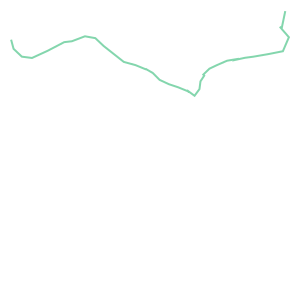

In [27]:
green_line_stations_gdf = geopandas.GeoDataFrame(green_line_stations_gdf, geometry='geometry_y')

green_line_stations_gdf['coordinates'] = green_line_stations_gdf['geometry_y'].centroid
green_line_stations_gdf

# create a linestring for the green line route
from shapely.geometry import LineString
green_line_route = LineString(green_line_stations_gdf['coordinates'])
green_line_route

In [28]:
buffered_green_line = green_line_route.buffer(buffer_distance)

overlap_distance_output_green = []

for i, route in tqdm(bus_routes_combined.iterrows()):
    overlap = buffered_green_line.intersection(route.geometry)
    if overlap.is_empty:
        overlap_distance_output_green.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': 0,
            'MRT line': 'East-West Line',
            'Intersection': overlap
            })
    else:
        overlap_distance_output_green.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': overlap.length,
            'MRT line': 'East-West Line',
            'Intersection': overlap
            })

overlap_distance_green = pd.DataFrame(overlap_distance_output_green)
overlap_distance_green

724it [00:00, 1277.06it/s]


,Bus Service,Direction,Overlap Distance,MRT line,Intersection
0,10,1,1340.259659,East-West Line,MULTILINESTRING ((11570925.355747303 150749.03...
1,10,2,2641.463991,East-West Line,MULTILINESTRING ((11560071.385840146 141962.95...
2,100,1,3314.870268,East-West Line,MULTILINESTRING ((11564090.923977466 146677.02...
3,100,2,5482.082006,East-West Line,MULTILINESTRING ((11554266.413370728 145465.34...
4,100A,1,136.330858,East-West Line,LINESTRING (11564090.923977466 146677.02607208...
...,...,...,...,...,...
719,992,1,0.000000,East-West Line,LINESTRING Z EMPTY
720,992,2,0.000000,East-West Line,LINESTRING Z EMPTY
721,993,1,2061.928194,East-West Line,MULTILINESTRING ((11548296.441725906 148445.60...
722,9A,1,4218.666279,East-West Line,MULTILINESTRING ((11569327.609406518 147460.11...


In [29]:
bus_routes_overlap_green = overlap_distance_green[overlap_distance_green['Overlap Distance'] > 0].sort_values(by = 'Overlap Distance', ascending = False)
bus_routes_overlap_green

,Bus Service,Direction,Overlap Distance,MRT line,Intersection
442,63,1,12990.561551,East-West Line,MULTILINESTRING ((11566296.397064393 146880.92...
234,2,2,12446.155483,East-West Line,MULTILINESTRING ((11559228.300616115 142395.85...
258,24,1,10583.601384,East-West Line,MULTILINESTRING ((11565199.245835643 146876.47...
607,9,1,8631.436216,East-West Line,MULTILINESTRING ((11569327.609406518 147460.11...
406,51,2,8626.680077,East-West Line,MULTILINESTRING ((11548347.742894938 148397.07...
...,...,...,...,...,...
369,39A,1,79.801168,East-West Line,LINESTRING (11571490.526500894 152774.11363990...
187,17A,1,79.410554,East-West Line,LINESTRING (11569327.609406518 147460.11332459...
590,87,2,79.410554,East-West Line,LINESTRING (11569327.609406518 147460.11332459...
589,87,1,76.194445,East-West Line,LINESTRING (11569287.456862347 147524.86953427...


In [30]:
bus_routes_overlap = pd.concat([bus_routes_overlap, bus_routes_overlap_green], axis = 0)
bus_routes_overlap

,Bus Service,Direction,Overlap Distance,MRT line,Intersection
349,36,1,10712.453056,Thomson-East Coast Line,MULTILINESTRING ((11570247.489187447 145943.63...
351,36B,1,9578.456098,Thomson-East Coast Line,MULTILINESTRING ((11569767.053458788 145922.54...
392,47,1,6577.674498,Thomson-East Coast Line,MULTILINESTRING ((11569834.788487667 146040.89...
350,36A,1,5153.463902,Thomson-East Coast Line,MULTILINESTRING ((11570247.489187447 145943.63...
225,196e,1,5141.642547,Thomson-East Coast Line,MULTILINESTRING ((11569767.053458788 145922.54...
...,...,...,...,...,...
369,39A,1,79.801168,East-West Line,LINESTRING (11571490.526500894 152774.11363990...
187,17A,1,79.410554,East-West Line,LINESTRING (11569327.609406518 147460.11332459...
590,87,2,79.410554,East-West Line,LINESTRING (11569327.609406518 147460.11332459...
589,87,1,76.194445,East-West Line,LINESTRING (11569287.456862347 147524.86953427...


# Circle Line (Yellow)

In [31]:
circle_line = mrt_stations_3857_2[mrt_stations_3857_2["line"] == "CC"]["STATION_NA"].tolist()

In [32]:
circle_line_stations_gdf = mrt_stations_3857_2[mrt_stations_3857_2['line'] == "CC"]

circle_line_stations_gdf["order"] = pd.to_numeric(green_line_stations_gdf["CODE"].str.slice(2, None))

# order circle stations based on list
circle_line_stations_gdf = circle_line_stations_gdf.sort_values('order')
circle_line_stations_gdf

,CODE,STATION_NA,LINE,COLOR,OPENING,TYPE,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,...,geometry_x,lat_lng,line,STN_NAM_DE,TYP_CD,STN_NAM,ATTACHEMEN,TYP_CD_DES,geometry_y,order
99,CC1,Dhoby Ghaut,Circle Line,Orange,2010-04-17,MRT,DHOBY GHAUT MRT STATION (CC1),13,ORCHARD ROAD,DHOBY GHAUT MRT STATION (CC1),...,POINT (29443.882 31252.572),POINT (1.299 103.846),CC,DHOBY GHAUT MRT STATION,0,None,None,MRT,"POLYGON ((11559965.996 144666.945, 11560032.60...",NaN
100,CC1,Dhoby Ghaut,Circle Line,Orange,2010-04-17,MRT,DHOBY GHAUT MRT STATION (CC1),13,ORCHARD ROAD,DHOBY GHAUT MRT STATION (CC1),...,POINT (29443.882 31252.572),POINT (1.299 103.846),CC,DHOBY GHAUT MRT STATION,0,None,NE6_DBG STN.zip,MRT,"POLYGON ((11560057.669 144610.631, 11560099.83...",NaN
101,CC1,Dhoby Ghaut,Circle Line,Orange,2010-04-17,MRT,DHOBY GHAUT MRT STATION (CC1),13,ORCHARD ROAD,DHOBY GHAUT MRT STATION (CC1),...,POINT (29443.882 31252.572),POINT (1.299 103.846),CC,DHOBY GHAUT MRT STATION,0,None,None,MRT,"POLYGON ((11560057.669 144610.631, 11560048.94...",NaN
102,CC2,Bras Basah,Circle Line,Orange,2010-04-17,MRT,BRAS BASAH MRT STATION (CC2),65,BRAS BASAH ROAD,BRAS BASAH MRT STATION (CC2),...,POINT (29930.767 31025.902),POINT (1.297 103.851),CC,BRAS BASAH MRT STATION,0,None,CC2_BBS STN.zip,MRT,"POLYGON ((11560546.586 144457.107, 11560562.03...",NaN
103,CC3,Esplanade,Circle Line,Orange,2010-04-17,MRT,ESPLANADE MRT STATION (CC3),90,BRAS BASAH ROAD,ESPLANADE MRT STATION (CC3),...,POINT (30421.993 30671.628),POINT (1.294 103.855),CC,ESPLANADE MRT STATION,0,None,CC3_EPN STN.zip,MRT,"POLYGON ((11561238.875 143970.789, 11561242.22...",NaN
104,CC4,Promenade,Circle Line,Orange,2010-04-17,MRT,PROMENADE MRT STATION (CC4),2,TEMASEK AVENUE,PROMENADE MRT STATION (CC4),...,POINT (31008.362 30709.258),POINT (1.294 103.86),CC,PROMENADE MRT STATION,0,None,CC4_PMN STN.zip,MRT,"POLYGON ((11561749.024 144127.673, 11561774.92...",NaN
105,CC4,Promenade,Circle Line,Orange,2010-04-17,MRT,PROMENADE MRT STATION (CC4),2,TEMASEK AVENUE,PROMENADE MRT STATION (CC4),...,POINT (31008.362 30709.258),POINT (1.294 103.86),CC,PROMENADE MRT STATION,0,None,None,MRT,"POLYGON ((11561725.013 144035.618, 11561732.57...",NaN
106,CC5,Nicoll Highway,Circle Line,Orange,2010-04-17,MRT,NICOLL HIGHWAY MRT STATION (CC5),20,REPUBLIC AVENUE,NICOLL HIGHWAY MRT STATION (CC5),...,POINT (31374.165 31347.153),POINT (1.3 103.864),CC,NICOLL HIGHWAY MRT STATION,0,None,CC5_NCH STN.zip,MRT,"POLYGON ((11561957.863 144678.764, 11561987.01...",NaN
107,CC6,Stadium,Circle Line,Orange,2010-04-17,MRT,STADIUM MRT STATION (CC6),3,STADIUM WALK,STADIUM MRT STATION (CC6),...,POINT (32676.348 31683.941),POINT (1.303 103.875),CC,STADIUM MRT STATION,0,None,CC6_SDM STN.zip,MRT,"POLYGON ((11563397.464 145082.341, 11563398.51...",NaN
108,CC7,Mountbatten,Circle Line,Orange,2010-04-17,MRT,MOUNTBATTEN MRT STATION (CC7),301,MOUNTBATTEN ROAD,MOUNTBATTEN MRT STATION (CC7),...,POINT (33476.563 32058.742),POINT (1.306 103.883),CC,MOUNTBATTEN MRT STATION,0,None,CC7_MBT STN.zip\r\nCC7_MBT STN.zip,MRT,"POLYGON ((11564045.348 145402.245, 11564050.87...",NaN


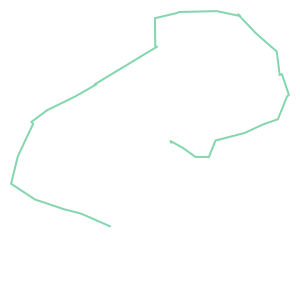

In [33]:
circle_line_stations_gdf = geopandas.GeoDataFrame(circle_line_stations_gdf, geometry='geometry_y')

circle_line_stations_gdf['coordinates'] = circle_line_stations_gdf['geometry_y'].centroid
circle_line_stations_gdf

# create a linestring for the circle line route
from shapely.geometry import LineString
circle_line_route = LineString(circle_line_stations_gdf['coordinates'])
circle_line_route

In [34]:
buffered_circle_line = circle_line_route.buffer(buffer_distance)

overlap_distance_output_circle = []

for i, route in tqdm(bus_routes_combined.iterrows()):
    overlap = buffered_circle_line.intersection(route.geometry)
    if overlap.is_empty:
        overlap_distance_output_circle.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': 0,
            'MRT line': 'Circle Line',
            'Intersection': overlap
            })
    else:
        overlap_distance_output_circle.append({
            'Bus Service': route['ServiceNo'],
            'Direction': route['Direction'],
            'Overlap Distance': overlap.length,
            'MRT line': 'Circle Line',
            'Intersection': overlap
            })

overlap_distance_circle = pd.DataFrame(overlap_distance_output_circle)
overlap_distance_circle

724it [00:00, 1153.29it/s]


,Bus Service,Direction,Overlap Distance,MRT line,Intersection
0,10,1,6990.730262,Circle Line,MULTILINESTRING ((11565002.693744075 145678.91...
1,10,2,6780.148840,Circle Line,MULTILINESTRING ((11552847.312767658 143033.07...
2,100,1,3232.659111,Circle Line,MULTILINESTRING ((11562943.630025776 150347.12...
3,100,2,3253.667605,Circle Line,MULTILINESTRING ((11553859.32296903 145734.807...
4,100A,1,207.850086,Circle Line,LINESTRING (11562943.630025776 150347.12028417...
...,...,...,...,...,...
719,992,1,0.000000,Circle Line,LINESTRING Z EMPTY
720,992,2,0.000000,Circle Line,LINESTRING Z EMPTY
721,993,1,0.000000,Circle Line,LINESTRING Z EMPTY
722,9A,1,0.000000,Circle Line,LINESTRING Z EMPTY


In [35]:
bus_routes_overlap_circle = overlap_distance_circle[overlap_distance_circle['Overlap Distance'] > 0].sort_values(by = 'Overlap Distance', ascending = False)
bus_routes_overlap_circle

,Bus Service,Direction,Overlap Distance,MRT line,Intersection
497,70M,1,8631.266710,Circle Line,MULTILINESTRING ((11563104.94635849 150483.913...
129,158,1,7683.686214,Circle Line,MULTILINESTRING ((11562943.630025776 150347.12...
236,200,1,7159.593955,Circle Line,MULTILINESTRING ((11554113.023137262 145748.82...
0,10,1,6990.730262,Circle Line,MULTILINESTRING ((11565002.693744075 145678.91...
1,10,2,6780.148840,Circle Line,MULTILINESTRING ((11552847.312767658 143033.07...
...,...,...,...,...,...
92,13A,1,139.165513,Circle Line,LINESTRING (11560269.529441975 150530.19989975...
142,162,1,102.368728,Circle Line,LINESTRING (11559261.958614247 150279.92370331...
36,116A,1,100.181166,Circle Line,LINESTRING (11563104.94635849 150483.913531073...
496,70B,1,100.181166,Circle Line,LINESTRING (11563104.94635849 150483.913531073...


In [36]:
bus_routes_overlap = pd.concat([bus_routes_overlap, bus_routes_overlap_circle], axis = 0)
bus_routes_overlap

,Bus Service,Direction,Overlap Distance,MRT line,Intersection
349,36,1,10712.453056,Thomson-East Coast Line,MULTILINESTRING ((11570247.489187447 145943.63...
351,36B,1,9578.456098,Thomson-East Coast Line,MULTILINESTRING ((11569767.053458788 145922.54...
392,47,1,6577.674498,Thomson-East Coast Line,MULTILINESTRING ((11569834.788487667 146040.89...
350,36A,1,5153.463902,Thomson-East Coast Line,MULTILINESTRING ((11570247.489187447 145943.63...
225,196e,1,5141.642547,Thomson-East Coast Line,MULTILINESTRING ((11569767.053458788 145922.54...
...,...,...,...,...,...
92,13A,1,139.165513,Circle Line,LINESTRING (11560269.529441975 150530.19989975...
142,162,1,102.368728,Circle Line,LINESTRING (11559261.958614247 150279.92370331...
36,116A,1,100.181166,Circle Line,LINESTRING (11563104.94635849 150483.913531073...
496,70B,1,100.181166,Circle Line,LINESTRING (11563104.94635849 150483.913531073...


# Bus Stops in Overlap

In [37]:
# find the bus stops that belong to each intersection between the bus routes and the MRT lines
bus_routes_overlap_gdf_3857 = geopandas.GeoDataFrame(bus_routes_overlap,
                                                     geometry = bus_routes_overlap['Intersection'],
                                                     crs = "EPSG:3857")

overlap_count_output = []

for i, row in tqdm(bus_routes_overlap_gdf_3857.iterrows()):
    bus_no = row['Bus Service']
    direction = row['Direction']
    bus = bus_routes_gdf_3857[(bus_routes_gdf_3857['ServiceNo'] == bus_no) & (bus_routes_gdf_3857['Direction'] == direction)]
    for j, stop in bus.iterrows():
        if row['Intersection'].contains(stop.geometry):
            overlap_count_output.append({
                'Bus Service': bus_no,
                'Direction': direction,
                'Bus Stop Code': stop['BusStopCode'],
                'Description': stop['Description'],
                'MRT line': row['MRT line'],
                'geometry': stop.geometry
            })

overlap_bus_stops = geopandas.GeoDataFrame(overlap_count_output, crs = "EPSG:3857")


4it [00:00, 32.17it/s]

2392it [00:32, 72.99it/s] 


In [38]:
overlap_bus_stops

,Bus Service,Direction,Bus Stop Code,Description,MRT line,geometry
0,36,1,93049,Lagoon View,Thomson-East Coast Line,POINT (11569767.053 145922.543)
1,36,1,93039,Siglap Stn/Laguna Park,Thomson-East Coast Line,POINT (11569383.643 145795.002)
2,36,1,93201,Victoria Sch,Thomson-East Coast Line,POINT (11569191.188 145752.165)
3,36,1,93029,Mandarin Gdns,Thomson-East Coast Line,POINT (11568845.851 145675.838)
4,36,1,93019,Neptune Ct,Thomson-East Coast Line,POINT (11568445.848 145604.752)
...,...,...,...,...,...,...
8577,81,1,66351,S'goon Stn Exit E,Circle Line,POINT (11563116.725 150350.707)
8578,109,2,66389,S'Goon Stn Exit F,Circle Line,POINT (11562874.515 150397.844)
8579,53M,1,66359,S'Goon Stn Exit C/Blk 201,Circle Line,POINT (11563121.31 150385.078)
8580,116,1,66359,S'Goon Stn Exit C/Blk 201,Circle Line,POINT (11563121.31 150385.078)


In [39]:
# get the number of bus stops in the intersection between each bus route mrt line
overlap_count = overlap_bus_stops.groupby(['Bus Service', 'Direction', 'MRT line']).size().reset_index(name = 'Count').sort_values('Count', ascending = False)

bus_routes_overlap = bus_routes_overlap.merge(overlap_count, on = ['Bus Service', 'Direction', 'MRT line'], how = 'outer')
bus_routes_overlap = bus_routes_overlap[bus_routes_overlap['Count'].notna()]
bus_routes_overlap['Count'] = bus_routes_overlap['Count'].astype(int)

In [40]:
bus_routes_overlap.sort_values(['Overlap Distance', 'Count'], ascending = False)

,Bus Service,Direction,Overlap Distance,MRT line,Intersection,Count
1647,67,2,16091.462313,Downtown Line,MULTILINESTRING ((11570925.355747303 150749.03...,43
1641,67,1,14353.211924,Downtown Line,MULTILINESTRING ((11550550.736296788 153470.92...,36
636,170,1,13688.136207,Downtown Line,MULTILINESTRING ((11561192.006549314 145157.14...,36
1442,63,1,12990.561551,East-West Line,MULTILINESTRING ((11566296.397064393 146880.92...,39
908,23,1,12961.825736,Downtown Line,MULTILINESTRING ((11570925.355747303 150749.03...,13
...,...,...,...,...,...,...
975,269,1,72.802420,North-South Line,MULTILINESTRING ((11560369.616077418 152487.46...,2
703,177,1,23.956965,North-South Line,MULTILINESTRING ((11549515.381030776 150294.50...,2
2098,920,1,10.275598,Downtown Line,MULTILINESTRING ((11550876.228613876 153427.09...,2
2099,922,1,10.275598,Downtown Line,MULTILINESTRING ((11550876.228613876 153427.09...,2
